In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
project_root = "/project_ghent/Mostafa/ActivityRecognition/DistInference"
project_root2 = "/project_ghent/Mostafa/ActivityRecognition/DistInference/src/DistInference"
os.chdir(project_root)
sys.path.append(project_root)
sys.path.append(project_root2)

from DistInference.models import My_Model
from DistInference.general_utils import load_config, print_module_summary


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from safetensors.torch import load_file

config = load_config("/project_ghent/Mostafa/ActivityRecognition/DistInference/config.yaml")
model = My_Model (config)


# Load the state_dict
state_dict = load_file("/project_ghent/Mostafa/ActivityRecognition/DistInference/trained_model/model.safetensors")

# Update the model with loaded weights
model.load_state_dict(state_dict)
model.eval();

Backbone 'resnet50' outputs 2048 features.


In [4]:
from DistInference.get_fold_dataloaders import get_dataloaders_from_config

config_path = "/project_ghent/Mostafa/ActivityRecognition/DistInference/config.yaml"
train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, fold_index = get_dataloaders_from_config(config_path)



{'folds_json': 'five_folds.json', 'fold_index': 0, 'train_split_percentage': 0.8, 'batch_sizes': {'train': 512, 'validation': 8, 'test': 1}, 'normalization': 'none', 'force_dim': 314, 'shuffle': {'train': True, 'validation': False, 'test': False}, 'additive_noise_std': {'train': 0.1, 'validation': 0.0, 'test': 0.0}, 'num_workers': {'train': 4, 'validation': 0, 'test': 0}, 'stft': {'window_size': 128, 'overlap': 64}, 'model': {'name': 'resnet50', 'num_classes': 6, 'input_channels': 1}, 'training': {'epochs': 1000, 'learning_rate': '8e-4', 'weight_decay': '1e-2', 'logging_steps': 10, 'save_steps': 100, 'evaluation_strategy': 'steps', 'eval_steps': 100, 'save_total_limit': 3}, 'inference': {'noise_level': 0.0}}


/project_ghent/Mostafa/ActivityRecognition/DistInference/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
from sklearn.metrics import confusion_matrix
import torch

# Assuming you have a device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model.to(device)

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Switch model to evaluation mode
model.eval()

# Disable gradient calculations for faster inference
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch[0], batch[1]
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Get model predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs['logits'], 1)  # Assuming outputs are logits
        
        # Collect predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[57  5  0  1  0  0]
 [ 0 63  0  0  0  0]
 [ 0  0 58  3  2  0]
 [ 0  1  5 34 23  0]
 [ 0  4  2  7 49  0]
 [ 0  0  4  0  2 34]]


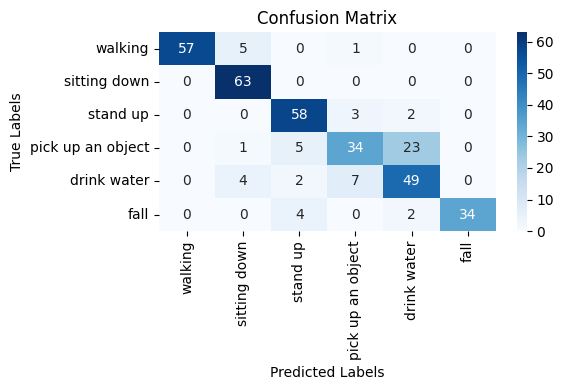

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Label mapping for readability
label_map = {
    0: 'walking',
    1: 'sitting down',
    2: 'stand up',
    3: 'pick up an object',
    4: 'drink water',
    5: 'fall'
}

# Get class labels for the confusion matrix
class_names = [label_map[i] for i in range(len(label_map))]

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [ ]:
import timm
timm.list_models();

Using device: cuda
GPU: NVIDIA A40
Backbone 'resnet50' outputs 2048 features.
Model loaded and set to evaluation mode.
{'folds_json': 'five_folds.json', 'fold_index': 0, 'train_split_percentage': 0.8, 'batch_sizes': {'train': 512, 'validation': 8, 'test': 1}, 'normalization': 'none', 'force_dim': 314, 'shuffle': {'train': True, 'validation': False, 'test': False}, 'additive_noise_std': {'train': 0.1, 'validation': 0.0, 'test': 0.0}, 'num_workers': {'train': 4, 'validation': 0, 'test': 0}, 'stft': {'window_size': 128, 'overlap': 64}, 'model': {'name': 'resnet50', 'num_classes': 6, 'input_channels': 1}, 'training': {'max_steps': 10000.0, 'learning_rate': '8e-4', 'weight_decay': '1e-2', 'logging_steps': 10, 'save_steps': 100, 'evaluation_strategy': 'steps', 'eval_steps': 100, 'save_total_limit': 3}, 'inference': {'noise_level': 0.0}}


/project_ghent/Mostafa/ActivityRecognition/DistInference/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Data loaders for validation and test datasets are ready.
Validation Accuracy: 0.8250
Test Accuracy: 0.8362


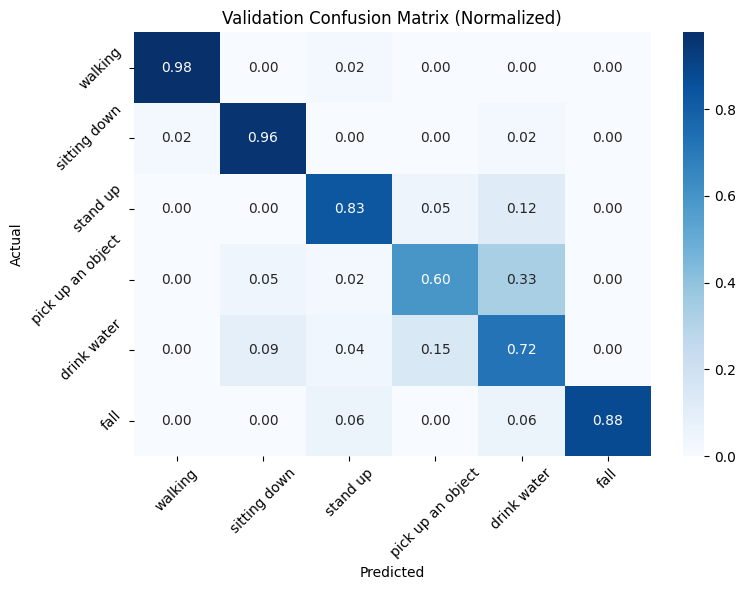

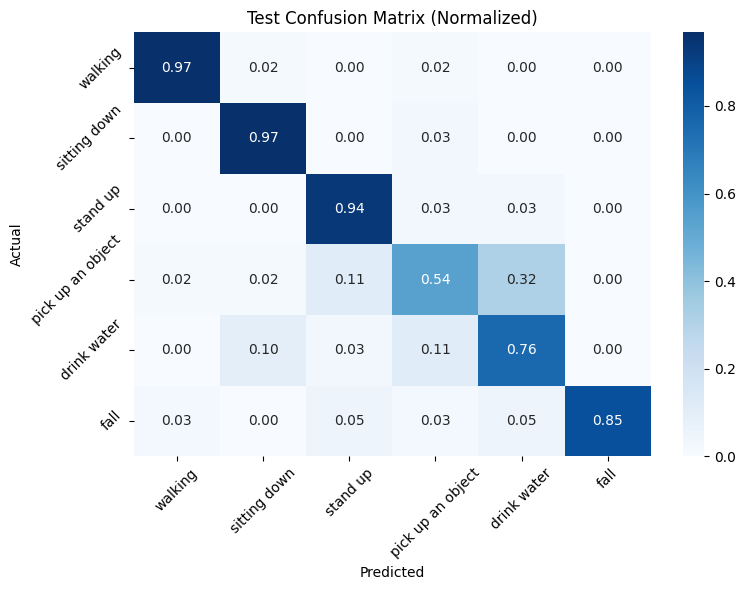

Confusion matrices saved as images.
Evaluation complete. Metrics computed and confusion matrices plotted.


In [6]:
# evaluate_model.ipynb

# %% [markdown]
# # Model Evaluation Notebook
# 
# This notebook evaluates a pretrained classifier on validation and test datasets. It computes overall accuracy and plots confusion matrices for each dataset.

# %% [markdown]
# ## 1. Imports and Setup

# %%
import os
import sys
import yaml
import random
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from safetensors.torch import load_file

# Custom modules (adjust the paths as necessary)
project_root = "/project_ghent/Mostafa/ActivityRecognition/DistInference"
project_root2 = "/project_ghent/Mostafa/ActivityRecognition/DistInference/src/DistInference"
os.chdir(project_root)
sys.path.append(project_root)
sys.path.append(project_root2)

from DistInference.models import My_Model
from DistInference.general_utils import load_config
from DistInference.get_fold_dataloaders import get_dataloaders_from_config

# %% [markdown]
# ## 2. Set Seed for Reproducibility

# %%
def set_seed(seed):
    """
    Set the seed for all relevant libraries to ensure reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# %% [markdown]
# ## 3. Load Configuration

# %%
config_path = "/project_ghent/Mostafa/ActivityRecognition/DistInference/config.yaml"
config = load_config(config_path)

# %% [markdown]
# ## 4. Set Seed

# %%
seed = config.get('training', {}).get('seed', 42)  # Default to 42 if not specified
set_seed(seed)

# %% [markdown]
# ## 5. Check CUDA Availability

# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# %% [markdown]
# ## 6. Load the Pretrained Model

# %%
# Initialize the model
model = My_Model(config)

# Path to the pretrained model weights
model_weights_path = "/project_ghent/Mostafa/ActivityRecognition/DistInference/trained_model/model.safetensors"

# Load the state_dict
state_dict = load_file(model_weights_path)

# Update the model with loaded weights
model.load_state_dict(state_dict)

# Move the model to the appropriate device
model.to(device)

# Set the model to evaluation mode
model.eval()

print("Model loaded and set to evaluation mode.")

# %% [markdown]
# ## 7. Prepare Data Loaders

# %%
# Function to create data loaders
def get_evaluation_dataloaders(config_path):
    """
    Retrieves validation and test dataloaders along with their datasets.

    Args:
        config_path (str): Path to the configuration file.

    Returns:
        val_loader (DataLoader): DataLoader for the validation set.
        test_loader (DataLoader): DataLoader for the test set.
        val_dataset (Dataset): Validation dataset.
        test_dataset (Dataset): Test dataset.
    """
    # Retrieve all dataloaders; we only need val and test
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset, fold_index = get_dataloaders_from_config(config_path)
    return val_loader, test_loader, val_dataset, test_dataset

# Get validation and test loaders
val_loader, test_loader, val_dataset, test_dataset = get_evaluation_dataloaders(config_path)

print("Data loaders for validation and test datasets are ready.")

# %% [markdown]
# ## 8. Define Metrics and Evaluation Function

# %%
def compute_metrics(preds, labels, num_classes):
    """
    Compute accuracy and confusion matrix.

    Args:
        preds (list or np.array): Predicted labels.
        labels (list or np.array): True labels.
        num_classes (int): Number of classes.

    Returns:
        accuracy (float): Accuracy score.
        cm (np.array): Confusion matrix.
    """
    # Compute accuracy
    accuracy = np.mean(np.array(preds) == np.array(labels))
    
    # Compute confusion matrix
    cm = confusion_matrix(labels, preds, labels=list(range(num_classes)))
    
    return accuracy, cm

def evaluate_model(model, dataloader, device, num_classes):
    """
    Evaluate the model on a given dataloader.
    Returns accuracy and confusion matrix.

    Args:
        model (nn.Module): The pretrained model.
        dataloader (DataLoader): DataLoader for the dataset to evaluate.
        device (torch.device): Device to run the evaluation on.
        num_classes (int): Number of classes.

    Returns:
        accuracy (float): Accuracy score.
        cm (np.array): Confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Batch is a list of two tensors: [inputs, labels]
            inputs, labels = batch[0].to(device), batch[1].to(device)
            
            outputs = model(inputs)
            
            # Access 'logits' from the model's output
            if isinstance(outputs, dict) and 'logits' in outputs:
                logits = outputs['logits']
            else:
                raise KeyError("Model output does not contain 'logits' key.")
            
            predictions = torch.argmax(logits, dim=-1)
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy, cm = compute_metrics(all_preds, all_labels, num_classes)
    return accuracy, cm

# %% [markdown]
# ## 9. Evaluate on Validation and Test Sets

# %%
num_classes = config['model']['num_classes']

# Evaluate on Validation Set
val_accuracy, val_cm = evaluate_model(model, val_loader, device, num_classes)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on Test Set
test_accuracy, test_cm = evaluate_model(model, test_loader, device, num_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

# %% [markdown]
# ## 10. Plot Confusion Matrix

# %% [markdown]
# ## 10. Plot Normalized Confusion Matrix

# %%
def plot_normalized_confusion_matrix(cm, class_names, title):
    """
    Plot and display the normalized confusion matrix.
    
    Args:
        cm (np.array): Confusion matrix.
        class_names (list): List of class names.
        title (str): Title for the plot.
    """
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title + " (Normalized)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Label mapping for readability
label_map = {
    0: 'walking',
    1: 'sitting down',
    2: 'stand up',
    3: 'pick up an object',
    4: 'drink water',
    5: 'fall'
}

# Get class labels for the confusion matrix
class_names = [label_map[i] for i in range(len(label_map))]


# Plot Normalized Validation Confusion Matrix
plot_normalized_confusion_matrix(val_cm, class_names, "Validation Confusion Matrix")

# Plot Normalized Test Confusion Matrix
plot_normalized_confusion_matrix(test_cm, class_names, "Test Confusion Matrix")


# %% [markdown]
# ## 11. Save Confusion Matrices (Optional)

# %%
# Optionally, save the confusion matrices as images
def save_confusion_matrix(cm, class_names, title, filename):
    """
    Save the confusion matrix as an image file.

    Args:
        cm (np.array): Confusion matrix.
        class_names (list): List of class names.
        title (str): Title for the plot.
        filename (str): Filename to save the plot.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# Save Validation Confusion Matrix
save_confusion_matrix(val_cm, class_names, "Validation Confusion Matrix", "validation_confusion_matrix.png")

# Save Test Confusion Matrix
save_confusion_matrix(test_cm, class_names, "Test Confusion Matrix", "test_confusion_matrix.png")

print("Confusion matrices saved as images.")

# %% [markdown]
# ## 12. Conclusion

# %%
print("Evaluation complete. Metrics computed and confusion matrices plotted.")
